# Framework de Validación Cruzada

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/datasets/_base.py:1472: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976036
  warnings.warn(f"Retry downloading from url: {remote.url}")


HTTPError: HTTP Error 403: Forbidden

En este dataset, el objetivo es predecir el valor medio de las casas en un área de California. 

- Las características se basan en información general de propiedades y geográficas.

In [ ]:
print(housing.DESCR)

In [ ]:
data.head()

In [ ]:
target.head()

In [ ]:
# Para simplificar la visualización, transformamos los precios del rango de mil dólares (k$) al rango de 100(k$).

target *= 100
target.head()

In [ ]:
target.describe()

# Error de entrenamiento vs error de prueba

In [ ]:
# Para resolver esta regresión, utilizaremos un regresor de árbol de decisión.

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

In [ ]:
# Después de entrenar al regresor, nos gustaría saber su posible rendimiento de generalización una vez implementado en producción.
# Para ello, usaremos el error absoluto medio, que nos da un error en la unidad nativa, es decir, K$.

from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"En promedio, nuestro regresor comete un error de {score:.2f} k$")

**Obtenemos una predicción perfecta, sin error!!**


> Es demasiado optimista y casi siempre revela un problema metodológico al hacer aprendizaje automático.

- De hecho, entrenamos y predijimos en el mismo conjunto de datos. 

**¿Qué sucede?**

A la vez que el árbol de decisión creció, cada muestra en el conjunto de datos se almacenó en un nodo de hoja.
- Por lo tanto, nuestro árbol de decisión memorizó completamente el conjunto de datos dado durante el ajuste y, por lo tanto, no cometió ningún error al predecir.
- Este error se llama **error empírico o error de entrenamiento.**

Entrenamos un modelo predictivo para minimizar el error de entrenamiento, pero nuestro objetivo es minimizar el error de los datos que no se han visto durante el entrenamiento.
- Este error también se llama **error de generalización** o **error de prueba "verdadero".**

**Por lo tanto, la evaluación más básica implica:**
- Dividir nuestro conjunto de datos en dos subconjuntos: un conjunto de entrenamiento y un conjunto de pruebas;
- Ajustar el modelo en el conjunto de entrenamiento;
- Estimat el error de entrenamiento en el conjunto de capacitación;
- Estimat el error de prueba en el conjunto de pruebas.

In [ ]:
# dividamos nuestro conjunto de datos.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [ ]:
# Entrenemos nuestra modelo.

regressor.fit(data_train, target_train)

In [ ]:
# Finalmente, estimamos los diferentes tipos de errores:
# calculamos el error de entrenamiento.

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"El error de entrenamiento de nuestro modelo es {score:.2f} k$")

In [ ]:
# Ahora, calculamos el error de prueba.

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"El error de prueba de nuestro modelo es {score:.2f} k$")

## Estabilidad de las estimaciones de validación cruzada
La **Validación cruzada** permite estimar **la robustez de un modelo predictivo** repitiendo el procedimiento de división.
- Dará varios errores de entrenamiento y prueba y, por tanto, se estimará la variabilidad del rendimiento de generalización del modelo.

Existen diferentes estrategias de validación cruzada. 
- https://scikit-learn.org/stable/modules/cross_validation.html

Vamos a centrarnos en **"Shuffle-Split"**. 
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

En cada iteración de esta estrategia:
- Se **baraja** al azar el orden de las muestras de una copia del conjunto de datos completo;
- Se **divide** el conjunto de datos barajado en entrenamiento y pruebas;
- Se **entrena** un nuevo modelo en el set de entrenamiento;
- Se **evalúa** el error de prueba en el conjunto de pruebas.
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

Repetimos este procedimiento **n_splits** veces.

*Tener en cuenta que el costo computacional aumenta con los n_splits.*

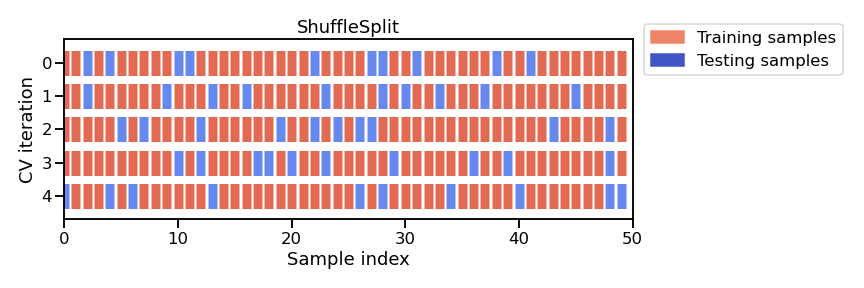


En este caso, estableceremos `n_splits = 40`: entrenaremos 40 modelos en total (todos se descartarán). Solo registramos su **rendimiento de generalización en cada variante del conjunto de pruebas**.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [ ]:
# Los resultados cv_results se almacenan en un diccionario de Python.
# Lo convertiremos en un Dataframe para facilitar la visualización y la manipulación.

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

In [ ]:
# error real = negativo del test_score ('neg_mean_absolute_error'):
cv_results["test_error"] = -cv_results["test_score"]

# Verifiquemos los resultados generados por la validación cruzada.
cv_results.head(10)

In [ ]:
len(cv_results)

In [ ]:
# Obtenemos 40 entradas en nuestro datset resultante porque realizamos 40 divisiones.
# podemos mostrar la distribución de errores de prueba y, por lo tanto, tener una estimación de su variabilidad.

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Error absoluto medio (k$)")
plt.title("Distribución de errores de prueba")

In [ ]:
# Observamos que el error de prueba se agrupa alrededor de 47 K$ y varía de 43 k$ a 50 k$.

print(f"El error medio de prueba multvalidada es: "
      f"{cv_results['test_error'].mean():.2f} k$")

In [ ]:
print(f"La desviación estándar del error de prueba es: "
      f"{cv_results['test_error'].std():.2f} k$")

In [ ]:
# la distribución de la variable objetivo:

target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Valor medio de la casa (k$)")
plt.title("Distribución objetivo")

In [ ]:
print(f"La desviación estándar del objetivo es: {target.std():.2f} k$")

## Más detalles sobre cross_validate

Durante la validación cruzada, muchos modelos son entrenados y evaluados. 

De hecho, el número de elementos en cada matriz de salida de cross_validate es el resultado de uno de estos procedimientos de fit/score. 

Para que sea explícito, es posible recuperar estos modelos ajustados para cada una de las divisiones/pliegues (splits/folds) pasando la opción `return_estimator = True` en cross_validate.

In [ ]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

In [ ]:
cv_results["estimator"]

In [ ]:
# En el caso de que solo nos interesemos en la puntuación de prueba, Scikit-Learn proporciona una función cross_val_score. 
# Es idéntico a llamar a la función cross_validate y seleccionar solo el test_score.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores